# Introduction: Advanced Automated Feature Engineering

In this notebook we will expand upon the "baseline" automated feature engineering done in the automated feature engineering notebook. We will explore a few different options for improving the set of features, most notably, creating time variables from the relative time information in the data. We can also explore creating seed features and "interesting variables". Reading through the discussion around this competition and working through some other's notebooks, intricate feature engineering is a must. Using the default feature transforms did improve our score, but to do better we will need some more advanced methods. 

In this notebook we will explore using the relative time measures to create new features. We already looked at using featuretools to generate almost a thousand new features, but did not use any time variables. Although there are not explicit time features, we can use the relative times, convert to a datetime, and then use these times to make new features. This might allow our model to captue time dependencies that exist in the data.

In [1]:
import pandas as pd
import numpy as np

import featuretools as ft

import warnings 

warnings.filterwarnings('ignore')

### Read in Data and Create Smaller Datasets

We will limit the data to 1000 rows because automated feature engineering is computationally intensive work. Later we can refactor this code into functions and put it in a script to run on a more powerful machine. 

In [2]:
# Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
# This allows us to actually see the results in a reasonable amount of time! 
app_train = pd.read_csv('../input/application_train.csv').sort_values('SK_ID_CURR').reset_index().loc[:500, :].drop(columns = ['index'])
app_test = pd.read_csv('../input/application_test.csv').sort_values('SK_ID_CURR').reset_index().loc[:500, :].drop(columns = ['index'])
bureau = pd.read_csv('../input/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index().loc[:1000, :].drop(columns = ['index'])
bureau_balance = pd.read_csv('../input/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index().loc[:1000, :].drop(columns = ['index'])
cash = pd.read_csv('../input/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
credit = pd.read_csv('../input/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
previous = pd.read_csv('../input/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
installments = pd.read_csv('../input/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])

In [3]:
# Join the appliation dataframes together
app_test['set'] = 'test'
app_test['TARGET'] = -999
app_train['set'] = 'train'

# Append the dataframes (this is a row bind in R)
app = app_train.append(app_test, ignore_index = True)

# Time Variable

We do not have any datetimes, but we can create our own using the provided day and month offsets. For example, in `bureau_balance`, the `MONTHS_BALANCE` column represents the "Month of balance relative to application date". Although we do not know the actual application date, if we assume a starting application date, then we can convert the `MONTHS_BALANCE` into a feature representing an actual time. While we do not know the absolute time, we can use the relative time to track progression of the loan. 

First we want to establish a starting date. All time measurements are relative to the application at Home Credit. We do not know when these applications are and they are all at different times. However, if we are only interested in relative changes, then we can choose any arbitrary starting date. 

In [4]:
# Establish a starting date for all applications at Home Credit
start_date = pd.Timestamp("2016-01-01")
start_date

Timestamp('2016-01-01 00:00:00')

In [5]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100001,5896630,Closed,currency 1,-857,0,-492.0,-553.0,NaN,0,112500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
1,100001,5896631,Closed,currency 1,-909,0,-179.0,-877.0,NaN,0,279720.0,0.0,0.0,0.0,Consumer credit,-155,0.0
2,100001,5896632,Closed,currency 1,-879,0,-514.0,-544.0,NaN,0,91620.0,0.0,0.0,0.0,Consumer credit,-155,0.0
3,100001,5896633,Closed,currency 1,-1572,0,-1329.0,-1328.0,NaN,0,85500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
4,100001,5896634,Active,currency 1,-559,0,902.0,NaN,NaN,0,337680.0,113166.0,0.0,0.0,Consumer credit,-6,4630.5


#### Bureau Data

First we will work with the `bureau` dataframe. This has 4 different columns representing date offsets:

* `DAYS_CREDIT`: Number of days before current application at Home Credit client applied for loan at other financial institution. We will call this the application date, `bureau_credit_application_date`
* `DAYS_CREDIT_ENDDATE`: Number of days of credit remaining at time of client's application at Home Credit. We will call this the ending date, `bureau_credit_end_date`
* `DAYS_ENDDATE_FACT`: For closed credits, the number of days before current application at Home Credit that credit at other financial institution ended. We will call this the closing date, `bureau_credit_close_date`. 
* `DAYS_CREDIT_UPDATE`: Number of days before current application at Home Credit that the most recent information about the previous credit arrived. We will call this the update date, `bureau_credit_update_date`. 

If we were doing manual feature engineering, we might want to create new columns such as by subtracting `DAYS_CREDIT_ENDDATE` from `DAYS_CREDIT` to get the planned length of the loan in days, or subtracting `DAYS_CREDIT_ENDDATE` from `DAYS_ENDDATE_FACT` to find the number of days the client paid off the loan early. However, in this notebook we will not make any features by hand, but rather let featuretools develop any potentially useful features for us.

To efficiently change dates in Pandas, we can convert the preceding columns to `Timedelta` objects. Then we just need to add these `Timedelta` objects to the preceding columns to create new columns the 'dates'. We need to specify that the time delta is in days.

In [6]:
# Convert to timedelta in days
for col in ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']:
    bureau[col] = pd.to_timedelta(bureau[col], 'D')

bureau[['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']].head()

,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE
0,-857 days,-492 days,-553 days,-155 days
1,-909 days,-179 days,-877 days,-155 days
2,-879 days,-514 days,-544 days,-155 days
3,-1572 days,-1329 days,-1328 days,-155 days
4,-559 days,902 days,NaT,-6 days


Then we just add the columns to create date columns.

In [7]:
# Create the date columns
bureau['bureau_credit_application_date'] = start_date + bureau['DAYS_CREDIT']
bureau['bureau_credit_end_date'] = start_date + bureau['DAYS_CREDIT_ENDDATE']
bureau['bureau_credit_close_date'] = start_date + bureau['DAYS_ENDDATE_FACT']
bureau['bureau_credit_update_date'] = start_date + bureau['DAYS_CREDIT_UPDATE']

### Plot for a sanity check

It can be easy to get lost in all the coding and lose track of the bigger picture. For that reason, let's make two plots: the first will be the difference beween `bureau_credit_applicate_date` and `bureau_credit_end_date`. This represents the planned length of the loan in days.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up default plot styles
plt.rcParams['font.size'] = 26
plt.style.use('fivethirtyeight')

D:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


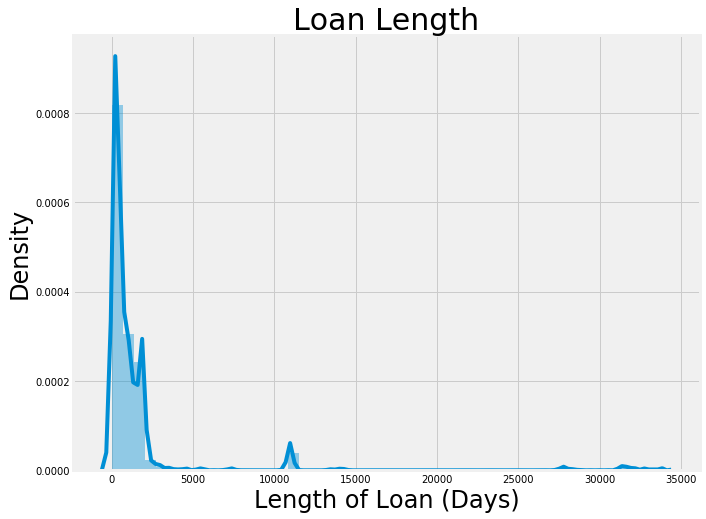

In [9]:
plt.figure(figsize = (10, 8))
sns.distplot((bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dropna().dt.days);
plt.xlabel('Length of Loan (Days)', size = 24); plt.ylabel('Density', size = 24); plt.title('Loan Length', size = 30);

It looks as if there are a number of loans that are unreasonably long. Let's single out those loans greater than 10000 days.

In [10]:
bureau[(bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dt.days > 10000].head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,bureau_credit_application_date,bureau_credit_end_date,bureau_credit_close_date,bureau_credit_update_date
81,100019,5832095,Active,currency 1,-495 days,0,10463 days,NaT,0.0,0,...,0.0,270000.0,0.0,Credit card,-46 days,27000.0,2014-08-24,2044-08-24,NaT,2015-11-16
113,100028,6356883,Active,currency 1,-1821 days,0,30885 days,NaT,NaN,0,...,7713.0,0.0,0.0,Credit card,-913 days,1624.5,2011-01-06,2100-07-24,NaT,2013-07-02
151,100035,5407257,Active,currency 1,-979 days,0,9980 days,NaT,2808.0,0,...,NaN,NaN,0.0,Credit card,-33 days,NaN,2013-04-27,2043-04-29,NaT,2015-11-29
195,100042,5574790,Active,currency 1,-2000 days,0,8957 days,NaT,999.0,0,...,NaN,NaN,0.0,Credit card,-10 days,40500.0,2010-07-11,2040-07-10,NaT,2015-12-22
261,100058,6552706,Active,currency 1,-223 days,0,31087 days,NaT,NaN,0,...,130819.5,NaN,0.0,Credit card,-18 days,NaN,2015-05-23,2101-02-11,NaT,2015-12-14


I'm not sure what's going on with these loans. For now, because we are concentrated on using featuretools, we will move on leaving all of the loans in the data. 
A second plot we can make is the number of days the client paid off the loan early. This is `bureau_credit_end_date` - `bureau_credit_close_date`. A positive number indicates the loan was paid off early while a negative number indicates the loan was paid off late. We will exclude any lengths over 1000 days. 

D:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


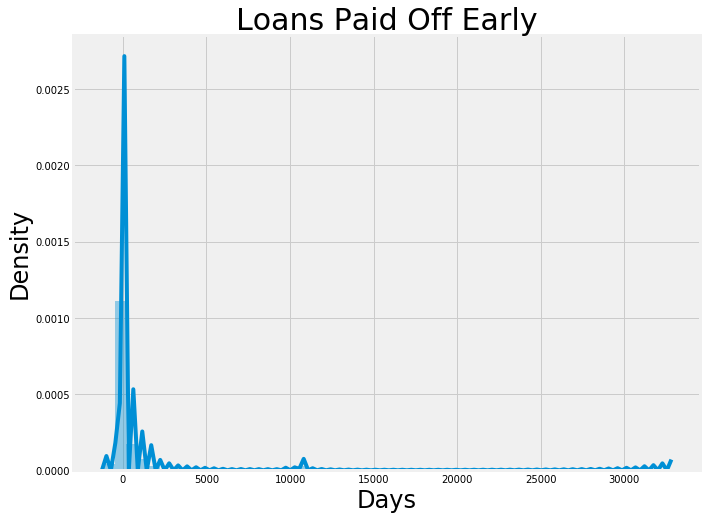

In [11]:
plt.figure(figsize = (10, 8))
sns.distplot((bureau['bureau_credit_end_date'] - bureau['bureau_credit_close_date']).dropna().dt.days);
plt.xlabel('Days', size = 24); plt.ylabel('Density', size = 24); plt.title('Loans Paid Off Early', size = 30);

Again we see a number of suspicious loans that were paid off tens of thousands of days early. We will leave this, but might want to revisit later. 

In [12]:
bureau = bureau.drop(columns = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE'])

#### Bureau Balance

The bureau balance dataframe has a `MONTHS_BALANCE` column that we can use as a months offset. The procedure is exactlt the same: convert to a `Timedelta` column and then subtract from the start date. We will name the new time column `bureau_balance_date`. 

In [13]:
# Convert to timedelta
bureau_balance['MONTHS_BALANCE'] = pd.to_timedelta(bureau_balance['MONTHS_BALANCE'], 'M')

# Make a date column
bureau_balance['bureau_balance_date'] = start_date + bureau_balance['MONTHS_BALANCE']
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,bureau_balance_date
0,5001709,-214 days +22:36:18,C,2015-06-01 22:36:18
1,5001709,-92 days +16:32:42,C,2015-10-01 16:32:42
2,5001709,-122 days +06:03:36,C,2015-09-01 06:03:36
3,5001709,-153 days +19:34:30,C,2015-08-01 19:34:30
4,5001709,-183 days +09:05:24,C,2015-07-02 09:05:24


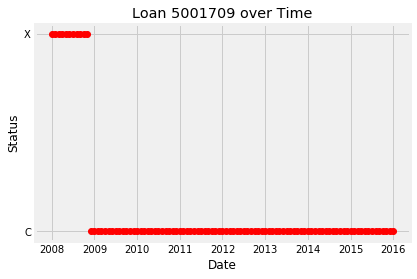

In [14]:
# Select on loan and plot
example_credit = bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709]

plt.plot(example_credit['bureau_balance_date'], example_credit['STATUS'], 'ro');
plt.title('Loan 5001709 over Time'); plt.xlabel('Date'); plt.ylabel('Status');

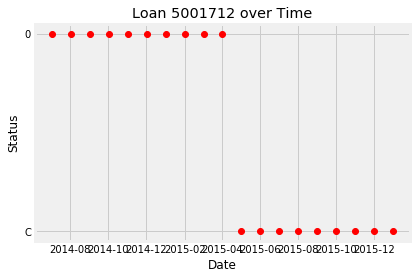

In [17]:
# Select one loan and plot
example_credit = bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001712]

plt.plot(example_credit['bureau_balance_date'], example_credit['STATUS'], 'ro');
plt.title('Loan 5001712 over Time'); plt.xlabel('Date'); plt.ylabel('Status');

In [18]:
bureau_balance = bureau_balance.drop(columns = ['MONTHS_BALANCE'])

### Previous Applications

The `previous` dataframe holds previous applications at Home Credit. There are a number of time offset columns in this dataset:

* `DAYS_DECISION`: number of days before current application at Home Credit that decision was made about previous application
* `DAYS_FIRST_DRAWING`: number of days before current application at Home Credit that first disbursement was made
* `DAYS_FIRST_DUE`: number of days before current application at Home Credit that first due was suppoed to be
* `DAYS_LAST_DUE_1ST_VERSION`: number of days before current application at Home Credit that first was??
* `DAYS_LAST_DUE`: number of days before current application at Home Credit of last due date of previous application
* `DAYS_TERMINATION`: number of days before current application at Home Credit of expected termination

Let's convert all these into timedeltas in a loop and then make time columns.

In [19]:
# Convert to timedeltas in days
for col in ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    try:
        previous[col] = pd.to_timedelta(previous[col], 'D')
    except Exception as e:
        print(col, e)

DAYS_FIRST_DRAWING int too big to convert
DAYS_FIRST_DUE int too big to convert
DAYS_LAST_DUE_1ST_VERSION int too big to convert
DAYS_LAST_DUE int too big to convert
DAYS_TERMINATION int too big to convert


In [20]:
previous['DAYS_FIRST_DRAWING'].describe()

count       568.000000
mean     346522.274648
std       80779.740446
min       -2866.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: DAYS_FIRST_DRAWING, dtype: float64

In [21]:
previous['DAYS_FIRST_DUE'].describe()

count       568.000000
mean      20786.410211
std       86996.664768
min       -2882.000000
25%       -1663.750000
50%        -844.500000
75%        -416.750000
max      365243.000000
Name: DAYS_FIRST_DUE, dtype: float64

It seems like the value '365243' is causing issues. We can replace that value with NaN to get the conversion to work. 

In [22]:
# Convert to timedeltas in days
for col in ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    try:
        previous[col] = previous[col].replace({365243: pd.NaT})
        previous[col] = pd.to_timedelta(previous[col], 'D')
    except Exception as e:
        print(col, e)

DAYS_DECISION Cannot compare types 'ndarray(dtype=timedelta64[ns])' and 'int'


In [23]:
# Make date columns
previous['previous_decision_date'] = start_date + previous['DAYS_DECISION']
previous['previous_drawing_date'] = start_date + previous['DAYS_FIRST_DRAWING']
previous['previous_first_due_date'] = start_date + previous['DAYS_FIRST_DUE']
previous['previous_last_duefirst_date'] = start_date + previous['DAYS_LAST_DUE_1ST_VERSION']
previous['previous_last_due_date'] = start_date + previous['DAYS_LAST_DUE']
previous['previous_termination_date'] = start_date + previous['DAYS_TERMINATION']

In [24]:
# Drop the time offset columns
previous = previous.drop(columns = ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'])
previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NFLAG_INSURED_ON_APPROVAL,previous_decision_date,previous_drawing_date,previous_first_due_date,previous_last_duefirst_date,previous_last_due_date,previous_termination_date
0,1369693,100001,Consumer loans,3951.000,24835.5,23787.0,2520.0,24835.5,FRIDAY,13,...,8.0,high,POS mobile with interest,0.0,2011-03-28,NaT,2011-04-28,2011-11-24,2011-07-27,2011-08-03
1,1038818,100002,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9,...,24.0,low_normal,POS other with interest,0.0,2014-05-05,NaT,2014-06-15,2016-05-05,2015-12-07,2015-12-15
2,1810518,100003,Cash loans,98356.995,900000.0,1035882.0,NaN,900000.0,FRIDAY,12,...,12.0,low_normal,Cash X-Sell: low,1.0,2013-12-16,NaT,2014-01-15,2014-12-11,2014-07-14,2014-07-23
3,2396755,100003,Consumer loans,6737.310,68809.5,68053.5,6885.0,68809.5,SATURDAY,15,...,12.0,middle,POS household with interest,1.0,2009-08-04,NaT,2009-09-04,2010-07-31,2010-07-31,2010-08-04
4,2636178,100003,Consumer loans,64567.665,337500.0,348637.5,0.0,337500.0,SUNDAY,17,...,6.0,middle,POS industry with interest,0.0,2013-09-25,NaT,2013-10-26,2014-03-25,2014-03-25,2014-04-02


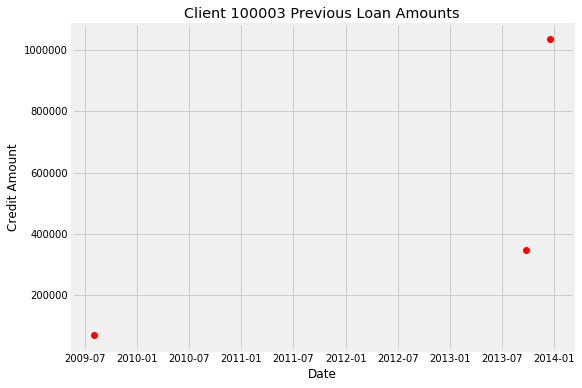

In [25]:
plt.figure(figsize = (8, 6))
example_client = previous[previous['SK_ID_CURR'] == 100003]
plt.plot(example_client['previous_decision_date'], example_client['AMT_CREDIT'], 'ro')
plt.title('Client 100003 Previous Loan Amounts'); plt.xlabel('Date'); plt.ylabel('Credit Amount');

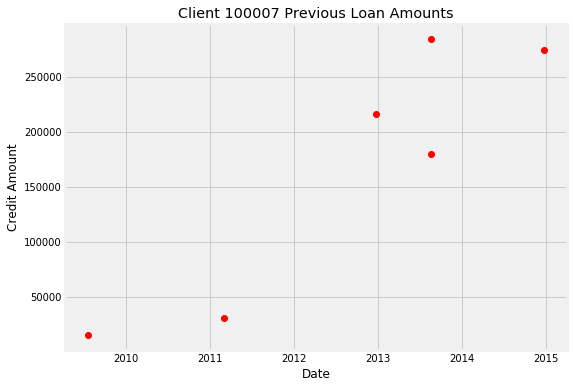

In [28]:
plt.figure(figsize = (8, 6))
example_client = previous[previous['SK_ID_CURR'] == 100007]
plt.plot(example_client['previous_decision_date'], example_client['AMT_CREDIT'], 'ro')
plt.title('Client 100007 Previous Loan Amounts'); plt.xlabel('Date'); plt.ylabel('Credit Amount');

#### Previous Credit and Cash

The `credit_card_balance` and `POS_CASH_balance` each have a `MONTHS_BALANCE` column with the month offset. This is the number of months before the current application at Home Credit of the previous application record. These will be converted to timedeltas and then dates can be added.

In [38]:
# Convert to timedelta objects
credit['MONTHS_BALANCE'] = pd.to_timedelta(credit['MONTHS_BALANCE'], 'M')
cash['MONTHS_BALANCE'] = pd.to_timedelta(cash['MONTHS_BALANCE'], 'M')

# Make a date column
credit['credit_balance_date'] = start_date + credit['MONTHS_BALANCE']
credit = credit.drop(columns = ['MONTHS_BALANCE'])

# Make a date column
cash['cash_balance_date'] = start_date + cash['MONTHS_BALANCE']
cash = cash.drop(columns = ['MONTHS_BALANCE'])

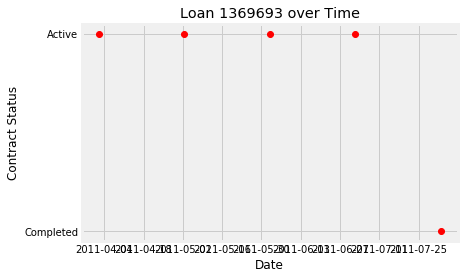

In [40]:
# Select on loan and plot
example_credit = cash[cash['SK_ID_PREV'] == 1369693]

plt.plot(example_credit['cash_balance_date'], example_credit['NAME_CONTRACT_STATUS'], 'ro');
plt.title('Loan 1369693 over Time'); plt.xlabel('Date'); plt.ylabel('Contract Status');

#### Installments Payments 

The `installments_payments` data contains information on each payment made on the previous loans at Home Credit. It has two date offset columns:

* `DAYS_INSTALMENT`: number of days before current application at Home Credit that previous installment was supposed to be paid
* `DAYS_ENTRY_PAYMENT`: number of days before current application at Home Credit that previous installment was actually paid

By now the process should be familiar: convert to timedeltas and then make time columns. 

In [34]:
# Conver to time delta object
installments['DAYS_INSTALMENT'] = pd.to_timedelta(installments['DAYS_INSTALMENT'], 'D')
installments['DAYS_ENTRY_PAYMENT'] = pd.to_timedelta(installments['DAYS_ENTRY_PAYMENT'], 'D')

# Create time column and drop
installments['installments_due_date'] = start_date + installments['DAYS_INSTALMENT']
installments = installments.drop(columns = ['DAYS_INSTALMENT'])

installments['installments_paid_date'] = start_date + installments['DAYS_ENTRY_PAYMENT']
installments = installments.drop(columns = ['DAYS_ENTRY_PAYMENT'])

In [41]:
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,AMT_INSTALMENT,AMT_PAYMENT,installments_due_date,installments_paid_date
0,1369693,100001,1.0,1,3951.00,3951.00,2011-04-28,2011-04-22
1,1369693,100001,1.0,2,3951.00,3951.00,2011-05-28,2011-04-22
2,1369693,100001,2.0,4,17397.90,17397.90,2011-07-27,2011-07-18
3,1369693,100001,1.0,3,3951.00,3951.00,2011-06-27,2011-06-16
4,1851984,100001,1.0,2,3982.05,3982.05,2008-01-07,2008-01-07


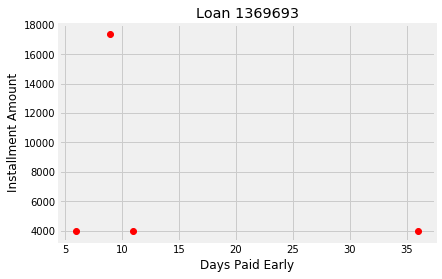

In [44]:
# Select on loan and plot
example_credit = installments[installments['SK_ID_PREV'] == 1369693]

plt.plot((example_credit['installments_due_date'] - example_credit['installments_paid_date']).dt.days, example_credit['AMT_INSTALMENT'], 'ro');
plt.title('Loan 1369693'); plt.xlabel('Days Paid Early'); plt.ylabel('Installment Amount');

# Feature Synthesis using Featuretools

We can now start making features based on the time columns. We will create an entityset named clients much as before, but now we have time variables that we can use. 

In [77]:
# Make an entityset
es = ft.EntitySet(id = 'clients')

## Encoding Categorical Variables

There are a number of columns in the `app` dataframe that are represented as integers but are really categorical variables. These represent flags that can only take on a limited number of values (usually 2). To tell featuretools to treat these as categorical variables, we need to pass in the correct datatype. After going through the column definitions, I identified all of the categorical variables. To pass these to featuretools, we need to make a dictionary mapping {`categorical_variable`: `ft.variable_types.Categorical`}. Luckily most of the categorical column names are similar so we do not need to specify each one by hand. 

In [78]:
app_categorical = {}

# Iterate through the columns and record the categorical columns
for col in app:
    if ('FLAG' in col) or ('REGION' in col) or ('CITY_NOT' in col):
        app_categorical[col] = ft.variable_types.Categorical

print('Number of categorical variables: ', len(app_categorical))

Number of categorical variables:  37


In [79]:
previous_categorical = {'FLAG_LAST_APPL_PER_CONTRACT': ft.variable_types.Categorical,
                        'NFLAG_LAST_APPL_IN_DAY': ft.variable_types.Categorical,
                        'NFLAG_INSURED_ON_APPROVAL': ft.variable_types.Categorical}

### Entities

When creating the entities, we specify the index, the time index (if present), and the variable types (if they need to be specified). 

In [80]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app', dataframe = app, 
                              index = 'SK_ID_CURR', variable_types = app_categorical)

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, 
                              index = 'SK_ID_BUREAU', time_index='bureau_credit_application_date')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, 
                              index = 'SK_ID_PREV', time_index = 'previous_decision_date',
                              variable_types = previous_categorical)

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bb_index',
                              time_index = 'bureau_balance_date')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index',
                              time_index = 'cash_balance_date')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index',
                              time_index = 'installments_paid_date')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index',
                              time_index = 'credit_balance_date')

### Relationships

Not surprisingly, the relationships between tables has not changed since the previous implementation. 

In [81]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

In [82]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  Entities:
    app [Rows: 1002, Columns: 123]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

# Deep Feature Synthesis

Now that we have time variables, we can apply deep feature synthesis and look at the generated features. In the previous notebook, we used the default aggregation and transformation primitives and then also specified a list of aggregation primitives. Here we will look at defining both aggregation and transformation primitives. 

At this point, having a __domain expert__ would be nice! Since we have no idea which features will actually be important, we will have to just make a bunch of features and then use some measure such as feature importances from a model to determine which should actually be kept. The primitives selected here are based on what has worked for others as well as guessing what might be important. 


## Aggregation Primitives


The default aggregation primitives in feature tools are:

`["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "n_unique", "mode"]`

To view the complete list, run the cell below.

In [83]:
# pd.options.display.max_colwidth = 200
# primitives = ft.list_primitives()
# primitives[primitives['type'] == 'aggregation']

It's difficult to say which of these will actually be important. For now, we can limit the aggregations to the following list

`['mean', 'max', 'min', 'trend', 'last', 'mode', 'count', 'percent_true', 'sum']`

### Transformation Primitives 

The default transformation primitives in featuretools are:

`["day", "year", "month", "weekday", "haversine", "num_words", "num_characters"]`

Since the time features we created are not actually "exact times" but are more important as relative times, we probably do not want to use features such as `day`, `year`, or `month`. To view the available transformation primitives, run the cell below.

In [84]:
# primitives[primitives['type'] == 'transform']

We will use the following transformation primitives:

`['diff', 'cum_sum', 'cum_mean', 'percentile']`

These primarily have been selected because they seem "interesting". Our approach at this point is just to make as many features as possible before we start paring them down. 

### Run DFS to see Features

At this point we will run Deep Feature Synthesis to look at the features which will be created. We specify `features_only=True` to only generate the feature names (and not the feature matrix). 

In [60]:
feature_names = ft.dfs(entityset = es, target_entity='app', 
                       agg_primitives = ['mean', 'max', 'min', 'trend', 'last', 'mode', 'count', 'percent_true', 'sum'],
                       trans_primitives = ['diff', 'cum_sum', 'cum_mean', 'percentile'],
                       max_depth = 2, features_only = True)

print('There are %d potential features using the specified aggregations.' % len(feature_names))

There are 3038 potential features using the specified aggregations.


# Interesting Features

Featuretools allows us to add in "interesting" features and then create new features conditioned on the interesting values of the variables. We might want to create some interesting values conditioned on specified categories of categorical variables. Let's look at one example using the `previous_applications` data.

In [85]:
previous['NAME_CONTRACT_STATUS'].value_counts()

Approved        594
Refused         206
Canceled        186
Unused offer     15
Name: NAME_CONTRACT_STATUS, dtype: int64

In [86]:
es['previous']['NAME_CONTRACT_STATUS'].interesting_values = ['Approved', 'Refused', 'Canceled', 'Unused offer']

Now featuretools will add in new features conditioned on these values. 

In [87]:
feature_names = ft.dfs(entityset=es, target_entity='app', max_depth = 2, 
                       agg_primitives=['mean'], 
                       where_primitives = ['mean'], 
                       trans_primitives=[], features_only = True)

i = 0
# Examine any conditioned features
for feature in feature_names:
    if i > 10:
        break
    if 'WHERE' in str(feature):
        print(feature)
        i += 1

<Feature: MEAN(previous.MEAN(installments.SK_ID_CURR) WHERE NAME_CONTRACT_STATUS = Unused offer)>
<Feature: MEAN(previous.MEAN(installments.SK_ID_CURR) WHERE NAME_CONTRACT_STATUS = Approved)>
<Feature: MEAN(previous.MEAN(installments.SK_ID_CURR) WHERE NAME_CONTRACT_STATUS = Refused)>
<Feature: MEAN(previous.MEAN(installments.SK_ID_CURR) WHERE NAME_CONTRACT_STATUS = Canceled)>
<Feature: MEAN(previous.MEAN(installments.NUM_INSTALMENT_VERSION) WHERE NAME_CONTRACT_STATUS = Unused offer)>
<Feature: MEAN(previous.MEAN(installments.NUM_INSTALMENT_VERSION) WHERE NAME_CONTRACT_STATUS = Approved)>
<Feature: MEAN(previous.MEAN(installments.NUM_INSTALMENT_VERSION) WHERE NAME_CONTRACT_STATUS = Refused)>
<Feature: MEAN(previous.MEAN(installments.NUM_INSTALMENT_VERSION) WHERE NAME_CONTRACT_STATUS = Canceled)>
<Feature: MEAN(previous.MEAN(installments.NUM_INSTALMENT_NUMBER) WHERE NAME_CONTRACT_STATUS = Unused offer)>
<Feature: MEAN(previous.MEAN(installments.NUM_INSTALMENT_NUMBER) WHERE NAME_CONTRACT_

Featuretools can add in interesting values for every categorical variables, but this might become overwhelming. For now, we will stick to using interesing values of the `NAME_CONTRACT_STATUS` from the `previous` dataframe as well as the `STATUS` column from the `bureau_balance` dataframe. 

In [90]:
bureau_balance['STATUS'].value_counts()

C    526
X    233
0    213
1     29
Name: STATUS, dtype: int64

In [93]:
es['bureau_balance']['STATUS'].interesting_values = ['X', '0']

## Seed Features

An aspect of featuretools that potentially allows us to include domain knowledge in the created features is seed features. These are manually defined features that featuretools will then build on top of where possible. We can show several examples here. A comprehensive coverage of seed features would involved examining the kernels posted to find the most useful features developed so far and then using those to build new features. For now, we will only make two seed features: whether or not an installment payment was less than the required amount, and whether or not previous loans at other institutions were paid off early. 

In [103]:
es['bureau']

Entity: bureau
  Variables:
    SK_ID_CURR (dtype: id)
    CREDIT_ACTIVE (dtype: categorical)
    CREDIT_CURRENCY (dtype: categorical)
    CREDIT_DAY_OVERDUE (dtype: numeric)
    AMT_CREDIT_MAX_OVERDUE (dtype: numeric)
    CNT_CREDIT_PROLONG (dtype: numeric)
    AMT_CREDIT_SUM (dtype: numeric)
    AMT_CREDIT_SUM_DEBT (dtype: numeric)
    AMT_CREDIT_SUM_LIMIT (dtype: numeric)
    AMT_CREDIT_SUM_OVERDUE (dtype: numeric)
    CREDIT_TYPE (dtype: categorical)
    AMT_ANNUITY (dtype: numeric)
    bureau_credit_application_date (dtype: datetime_time_index)
    bureau_credit_end_date (dtype: datetime)
    bureau_credit_close_date (dtype: datetime)
    bureau_credit_update_date (dtype: datetime)
    SK_ID_BUREAU (dtype: index)
  Shape:
    (Rows: 1001, Columns: 17)

In [104]:
late_installment = ft.primitives.Feature(es['installments']['AMT_INSTALMENT']) > ft.primitives.Feature(es['installments']['installments_due_date'])
late_installment = late_installment.rename("late_installment")

paid_early_bureau = ft.primitives.Feature(es['bureau']['bureau_credit_close_date']) < ft.primitives.Feature(es['bureau']['bureau_credit_end_date'])
paid_early_bureau = paid_early_bureau.rename("paid_early_bureau")

In [108]:
feature_names = ft.dfs(entityset=es, target_entity='app', agg_primitives=['percent_true', 'sum'], trans_primitives=[],
                       seed_features = [late_installment, paid_early_bureau], max_depth = 2, features_only = True)

i = 0
# Display new features built on the seed features
for feature in feature_names:
    if i > 10:
        break
    if ('late_installment' in str(feature)) or ('paid_early_bureau' in str(feature)):
        print(feature)
        i += 1

<Feature: PERCENT_TRUE(bureau.paid_early_bureau)>
<Feature: PERCENT_TRUE(installments.late_installment)>
<Feature: SUM(previous.PERCENT_TRUE(installments.late_installment))>


We can see that featuretools built new features on top of the seed features. Again, we could go much further in depth with this functionality if we spent some time searching for features that others have developed which are helpful. 

# Putting it all Together

Finally, we can run deep feature synthesis with the time variables, with the correct specified categorical variables, with the interesting features, and with the seed features. We'll only generate the feature names and then we can take the code, put it into a script, and use it to generate actual features.

In [109]:
# DFS with agg, trans, where, and seed (only names)
feature_names = ft.dfs(entityset = es, target_entity = 'app',
                       agg_primitives = ['mean', 'max', 'min', 'trend', 'last', 'mode', 'count', 'sum', 'percent_true'],
                       trans_primitives = ['diff', 'cum_sum', 'cum_mean', 'percentile'], 
                       where_primitives = ['mean', 'sum'],
                       seed_features = [late_installment, paid_early_bureau],
                       max_depth = 2, features_only = True)

print('There are a total of %d features.' % len(feature_names))

There are a total of 4834 features.


In [111]:
import random
random.sample(feature_names, 10)

[<Feature: MEAN(bureau.CUM_MEAN(AMT_CREDIT_SUM_LIMIT by SK_ID_CURR))>,
 <Feature: TREND(previous.LAST(credit.AMT_DRAWINGS_ATM_CURRENT), LAST(installments.installments_paid_date))>,
 <Feature: MIN(previous.SUM(cash.SK_ID_CURR))>,
 <Feature: SUM(previous.MIN(cash.SK_DPD))>,
 <Feature: TREND(previous.SUM(credit.AMT_CREDIT_LIMIT_ACTUAL), LAST(cash.cash_balance_date))>,
 <Feature: TREND(previous.MEAN(credit.CNT_DRAWINGS_CURRENT), LAST(cash.cash_balance_date))>,
 <Feature: PERCENTILE(MAX(previous.RATE_INTEREST_PRIVILEGED))>,
 <Feature: MAX(previous.CUM_MEAN(AMT_APPLICATION by SK_ID_CURR))>,
 <Feature: SUM(previous.MEAN(installments.AMT_INSTALMENT) WHERE NAME_CONTRACT_STATUS = Canceled)>,
 <Feature: LAST(previous.SUM(cash.CNT_INSTALMENT))>]

# Conclusions 

In this notebook we look at some of the more advanced functionality in featuretools. We can use these methods to encode domain knowledge and try to extract as much useful information from the given data as possible. The next step is to implement this code in a script on a high-powered computer. Then we can use the features for modeling, determine which are the most important, perform feature selection, and maybe perform feature synthesis with a new set of of primitives, seed features, and interesting features. As with many aspects of machine learning, feature creation is largely an empirical and iterative procedure. 